# Phase field damage

The Classical framework of a brittle fracture is built on an energy minimization,
where the bulk elastic energy competes with the dissipation caused by fracture.
The minimized functional have following form

\begin{equation}
    \mathcal{E}(\mathbf{u},\Gamma,t)
    = \int_{\Omega\setminus\Gamma} {\psi_\text{e}({\boldsymbol\varepsilon(\mathbf{u})})} \, \mathrm{d}V
    + G_\mathrm{f} \int_{\Gamma} \, \mathrm{d}S
    - \int_{\Omega} \mathbf{b}(t) \cdot \mathbf{u} \, \mathrm{d}V
    -\int_{\partial\Omega} \mathbf{g}(t) \cdot \mathbf{u} \, \mathrm{d}S,
\end{equation}
where $\mathbf{u}$ stands for the displacement, $\Gamma$ is the crack, $t$ denotes time,
$\psi$ is the elastic deformation energy and $G_\mathrm{f}$ is the fracture toughness.
The solution $(\mathbf{u}(t), \Gamma(t))$ is sought in the space
$(\mathcal{U} + \bar{\mathbf{u}}(t)) \times \mathcal{G}$,
where $\mathcal{U}$ is the set of kinematically admissible displacements,
$\bar{\mathbf{u}}(t)$ is the extension of the Dirichlet boundary condition
and $\mathcal{G}$ is the set of topologically admissible cracks.
Rougly speaking, $\mathbf{u}(t)$
*may* jump only on the crack $\Gamma$(t),
which has to be 'nice surface/curve' and not an ugly set.

Since it is difficult to solve this problem numerically,
it is often relaxed by smearing of the crack.
The corresponding formulation then reads
\begin{equation}
    (\mathbf{u}(t), d(t))
    = \mathrm{argmin}_{(\tilde{\mathbf{u}}, \tilde{d}) \in (\mathcal{U} + \bar{\mathbf{u}}(t)) \times \mathcal{D}}\,
    \mathcal{E}(\tilde{\mathbf{u}}, \tilde{d},t),
\end{equation}
where
\begin{equation}
    \mathcal{E}({\mathbf u},d,t)
    = \int_{\Omega} {(1-d)^2 \psi_\text{e}({\boldsymbol\varepsilon(\mathbf{u})})} \, \mathrm{d}V
    + \frac{3G_\mathrm{f}}{8} \int_{\Omega}\frac{1}{l}d + l | \nabla d |^2 \, \mathrm{d}V
    - \int_{\Omega}\mathbf{b}(t) \cdot\mathbf{u} \, \mathrm{d}V
    - \int_{\partial\Omega} \mathbf{g}(t) \cdot\mathbf{u} \, \mathrm{d} S,
\end{equation}
and $l$ is the regularization parameter.

## Monolithic solver

\begin{equation}
    \{\mathbf{u}(\mathbf{x}), d\} = \mathrm{argmin}_{\{\tilde{\mathbf{u}}, \tilde{d}\in\mathcal{U}\times\mathcal{D}\}}\ \mathcal{E}(\tilde{\mathbf{u}}, \tilde{d}),
\end{equation}

### Implementation

0.02599742200826581


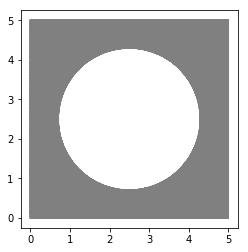

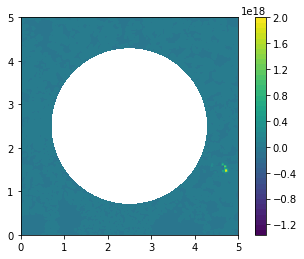

In [4]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return on_boundary and fe.near(x[1], 0.0)


def top(x, on_boundary):
    return on_boundary and fe.near(x[1], l_y)


def crack_line(x, on_boundary):
    return x[0] < 0.5 * l_x and abs(x[1]-0.5*l_y) < 0.02*l_y


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


def psi(u):
    return 0.5*fe.inner(epsilon(u), sigma(u))


def solve_snes_problem():
    fa.assign(lower, [ninfty, fe.interpolate(X.sub(1), W)])

    F = fe.derivative(E, X, fe.TestFunction(M))
    H = fe.derivative(F, X, fe.TrialFunction(M))

    snes_solver_parameters = {"nonlinear_solver": "snes",
                              "snes_solver": {"linear_solver": "lu",
                                              "relative_tolerance": 1e-4,
                                              "maximum_iterations": 20,
                                              "report": True,
                                              "error_on_nonconvergence": False}}

    problem = fe.NonlinearVariationalProblem(F, X, bc, H)
    problem.set_bounds(lower, upper)

    solver = fe.NonlinearVariationalSolver(problem)
    solver.parameters.update(snes_solver_parameters)
    solver.solve()


# --------------------
# Parameters
# --------------------
# Lame's constants
lmbda = 1.25
mu = 1

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 100, 100  # Number of elements

# Load
b_int = 0.0
C = 3.0e-2
l_c = 0.08

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)
mesh = fe.Mesh("external_mesh.xml")

print(mesh.hmin())

fe.plot(mesh)
plt.show()

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
W = fe.FunctionSpace(mesh, "CG", 1)
P1 = fe.VectorElement("P", fe.triangle, 1)
P2 = fe.FiniteElement("P", fe.triangle, 1)
element = fe.MixedElement([P1, P2])
M = fe.FunctionSpace(mesh, element)
X = fe.Function(M)
u, d = fe.split(X)

lower_d = fe.interpolate(fe.Constant(0.0), W)
upper_d = fe.interpolate(fe.Constant(1.0), W)
lower = fe.Function(M)
upper = fe.Function(M)
ninfty = fe.Function(V)
ninfty.vector()[:] = -np.infty
pinfty = fe.Function(V)
pinfty.vector()[:] = np.infty

fa = fe.FunctionAssigner(M, [V, W])
fa.assign(lower, [ninfty, lower_d])
fa.assign(upper, [pinfty, upper_d])

# --------------------
# Boundary conditions
# --------------------
u_d = fe.Expression("t", t=0.0, degree=0)
bc1 = fe.DirichletBC(M.sub(0), fe.Constant((0.0, 0.0)), bottom)
bc2 = fe.DirichletBC(M.sub(0).sub(1), u_d, top)
bc3 = fe.DirichletBC(M.sub(0).sub(0), 0.0, top)
bc4 = fe.DirichletBC(M.sub(1), 1.0, crack_line)
bc = [bc1, bc2, bc3]

# --------------------
# Governing functional
# --------------------
E = (1 - d)**2*psi(u)*fe.dx + C*(d/l_c + l_c*fe.grad(d)**2)*fe.dx

file_u = fe.XDMFFile('u.xdmf')
file_u.parameters["flush_output"] = True
file_d = fe.XDMFFile('d.xdmf')
file_d.parameters["flush_output"] = True

# --------------------
# Loop
# --------------------
ts = np.linspace(0, 1.0, 20)

for t in ts:
    u_d.t = t

    solve_snes_problem()

    u, d = X.split(deepcopy=True)
    file_u.write(u, t)
    file_d.write(d, t)

file_u.close()
file_d.close()

plot_d = fe.plot(d)
plt.colorbar(plot_d)
plt.show()


## Staggered solver (operator splitting?)

\begin{equation}
    \mathbf{u}_i = \mathrm{argmin}_{\tilde{\mathbf{u}}\in\mathcal{U}}\ \mathcal{E}(\tilde{\mathbf{u}}, d_{i-1}),\\
    d_i = \mathrm{argmin}_{\tilde{d}\in\mathcal{D}}\ \mathcal{E}(\mathbf{u}_i, \tilde{d}),
\end{equation}
repeated until converges

### Implementation

0.02599742200826581


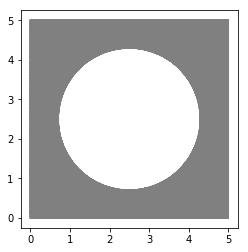

iter 1 , errors= 1.0 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.0333333333333386 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.03225806451612912 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.03125000000000006 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.030303030303030314 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.029411764705882304 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.028571428571428494 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.027777777777777853 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.027027027027027136 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.02631578947368416 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.025641025641025723 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.025000000000000015 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.02439024390243892 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.023809523809523787 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0.023255813953488445 0.0
iter 2 , errors= 0.0 0.0
iter 1 , errors= 0

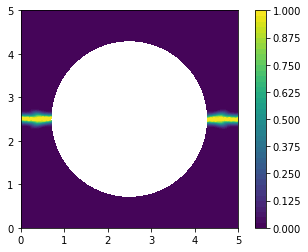

In [5]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return on_boundary and fe.near(x[1], 0.0)


def top(x, on_boundary):
    return on_boundary and fe.near(x[1], l_y)


def crack_line(x, on_boundary):
    return x[0] < 0.5 * l_x and abs(x[1]-0.5*l_y) < 0.02*l_y


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


def psi(u):
    return 0.5*fe.inner(epsilon(u), sigma(u))


def solve_displacement():
    F = fe.derivative(E, u, fe.TestFunction(V))
    H = fe.derivative(F, u, fe.TrialFunction(V))

    problem = fe.NonlinearVariationalProblem(F, u, bc_u, H)
    solver = fe.NonlinearVariationalSolver(problem)
    solver.solve()


def solve_damage():
    F = fe.derivative(E, d, fe.TestFunction(W))
    H = fe.derivative(F, d, fe.TrialFunction(W))

    snes_solver_parameters = {"nonlinear_solver": "snes",
                              "snes_solver": {"linear_solver": "lu",
                                              "relative_tolerance": 1e-4,
                                              "maximum_iterations": 20,
                                              "report": True,
                                              "error_on_nonconvergence": False}}

    problem = fe.NonlinearVariationalProblem(F, d, bc_d, H)
    problem.set_bounds(lower_d, upper_d)

    solver = fe.NonlinearVariationalSolver(problem)
    solver.parameters.update(snes_solver_parameters)
    solver.solve()


def solve_staggered_problem():
    tol = 1.0e-4
    ite = 1
    err = 10.0
    max_iter = 20
    lower_d.assign(d)
    while err > tol:
        solve_displacement()
        solve_damage()

        du.assign(u - u_old)
        dd.assign(d - d_old)

        err_u = fe.norm(du)/fe.norm(u)
        err_d = fe.norm(dd)
        err = max(err_u, err_d)

        print("iter", ite, ", errors=", err_u, err_d)

        u_old.assign(u)
        d_old.assign(d)

        ite += 1

        if ite > max_iter:
            print("max iterations reached")
            break


# --------------------
# Parameters
# --------------------
# Lame's constants
lmbda = 1.25
mu = 1

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 100, 100  # Number of elements

# Load
b_int = 0.0
C = 3.0e-2
l_c = 0.08

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)
mesh = fe.Mesh("external_mesh.xml")

print(mesh.hmin())

fe.plot(mesh)
plt.show()

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
W = fe.FunctionSpace(mesh, "CG", 1)
u = fe.Function(V)
u_old = fe.Function(V)
du = fe.Function(V)
d = fe.Function(W)
d_old = fe.Function(W)
dd = fe.Function(W)

u_bar = fe.Function(V)
v = fe.Function(V)
dv = fe.Function(V)
dv_old = fe.Function(V)

lower_d = fe.interpolate(fe.Constant(0.0), W)
upper_d = fe.interpolate(fe.Constant(1.0), W)

# --------------------
# Boundary conditions
# --------------------
u_d = fe.Expression("t", t=0.0, degree=0)
bc1 = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)
bc2 = fe.DirichletBC(V.sub(1), u_d, top)
bc3 = fe.DirichletBC(V.sub(0), 0.0, top)
bc4 = fe.DirichletBC(W, 1.0, crack_line)
bc_u = [bc1, bc2, bc3]
bc_d = []

# --------------------
# Governing functional
# --------------------
E = (1 - d)**2*psi(u)*fe.dx + C*(d/l_c + l_c*fe.grad(d)**2)*fe.dx

file_u = fe.XDMFFile('u_stag.xdmf')
file_u.parameters["flush_output"] = True
file_d = fe.XDMFFile('d_stag.xdmf')
file_d.parameters["flush_output"] = True

# --------------------
# Loop
# --------------------
ts = np.linspace(0.5, 1.0, 30)

for t in ts:
    u_d.t = t

    solve_staggered_problem()

    file_u.write(u, t)
    file_d.write(d, t)

file_u.close()
file_d.close()

plot_d = fe.plot(d)
plt.colorbar(plot_d)
plt.show()